# import libraries and data

In [21]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
from sklearn.svm import SVC, SVR
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold, permutation_test_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from datetime import date
import itertools
import random
import warnings
warnings.filterwarnings('ignore')

sns.set(context='paper', style='white', font='Arial')

today = date.today().strftime('%Y%m%d')

project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/'
data_dir = project_dir + 'proc/group/parcel_timeseries/sub_ts/'
clin_dir = project_dir + 'proc/clin/'

sample_file = project_dir + 'proc/group/datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
atlas_file = project_dir + 'proc/null_lL_WG33/Gordon333_SeitzmanSubcortical.32k_fs_LR.dlabel.nii'

ax0 = nib.load(sample_file).header.get_axis(0)
ax1 = nib.load(sample_file).header.get_axis(1)

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# load subject info
subinfo = pd.read_csv(project_dir + 'proc/group/datasets/firstleveldatalabels_withpub_thresh0.8_20220412.csv', index_col=0)
data = np.load(project_dir + 'proc/group/datasets/firstleveldata_thresh0.8_20220412.npy')
subinfo.index.name='sub'

scaredsr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_SR_20210322.csv'), 
                       index_col='EID', skiprows=[1]).loc[:,['SCARED_SR_SC','SCARED_SR_GD','SCARED_SR_SP']]
scaredsr.index = ['sub-{0}'.format(a) for a in scaredsr.index]
scaredsr.index.name = 'sub'

scaredpr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_P_20210322.csv'), 
                       index_col='EID', skiprows=[1]).loc[:,['SCARED_P_SC','SCARED_P_GD','SCARED_P_SP']]
scaredpr.index = ['sub-{0}'.format(a) for a in scaredpr.index]
scaredpr.index.name = 'sub'

mfqsr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_MFQ_SR_20210322.csv'), 
                    index_col='EID', skiprows=[1]).loc[:,'MFQ_SR_Total']
mfqsr.index = ['sub-{0}'.format(a) for a in mfqsr.index]
mfqsr.index.name = 'sub'

mfqpr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_MFQ_P_20210322.csv'), 
                    index_col='EID', skiprows=[1]).loc[:,'MFQ_P_Total']
mfqpr.index = ['sub-{0}'.format(a) for a in mfqpr.index]
mfqpr.index.name = 'sub'

adhd = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SWAN_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'SWAN_Avg']
adhd.index = ['sub-{0}'.format(a) for a in adhd.index]
adhd.index.name = 'sub'

subinfo = subinfo.merge(mfqsr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(mfqpr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredsr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredpr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(adhd, how='left', left_index=True, right_index=True)
subinfo = subinfo.drop_duplicates()

In [12]:
# assign developmental groups
subinfo['age_group'] = 'younger'
subinfo.loc[(subinfo['age']>10), 'age_group'] = 'older'

subinfo.loc[np.isfinite(subinfo['PPS_score']), 'pub_group'] = 'middle'
subinfo.loc[(subinfo['PPS_score']<=5),'pub_group'] = 'pre'
subinfo.loc[(subinfo['PPS_score']>5) & (subinfo['PPS_score']<=10),'pub_group'] = 'early'
subinfo.loc[(subinfo['PPS_score']>=15), 'pub_group'] = 'late'

train_labels = subinfo.loc[subinfo['site']=='rubic',:]
train_data = data[subinfo['site']=='rubic', :]
test_labels = subinfo.loc[subinfo['site']=='cbic',:]
test_data = data[subinfo['site']=='cbic', :]

In [ ]:
train_labels.describe()

In [ ]:
test_labels.describe()

# Set up analysis functions and class

In [7]:
def cv_fit(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']

    for i, a in enumerate(results['estimator']):
        c = np.expand_dims(a.coef_, axis=2)
        if i==0:
            weights = c
        else:
            weights = np.concatenate([weights, c], axis=2)
    
    estimators = results['estimator']
    weights = np.absolute(weights)
    mean_weights = np.mean(np.mean(weights, axis=2), axis=0, keepdims=True)
    return(estimators, weights, mean_weights, Y_pred, train_scores)

def cv_fit_poly(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
        
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']
    estimators = results['estimator']
    return(estimators, Y_pred, train_scores)


def bootstrap_train_score(model, X, Y, groups, cv, outdir, kind='classifier', ci=90, samples=10000):
    
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    train_scores = []
    corrcoeffs = []

    for a in range(0,samples):
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]
        g_temp = groups[subsampmask==1]
        results = cross_validate(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10,
                                 cv=cv, return_estimator=False, scoring=scoring)
        train_scores.append(results['test_score'])

        if kind=='regress':
            Y_t = cross_val_predict(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10, cv=cv)
            r, p = scp.spearmanr(Y_temp, Y_t)
            corrcoeffs.append(r)

    # test if boot strapped distibution is normally distributed
    train_scores = np.concatenate(train_scores).flatten()
    k , p = scp.kstest(train_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['train_scores','boot_mean'] = np.mean(train_scores)
    results.loc['train_scores','boot_SD'] = np.std(train_scores)
    results.loc['train_scores','boot_median'] = np.percentile(train_scores, 50)
    results.loc['train_scores','CI'] = ci
    results.loc['train_scores','lowerCI'] = np.percentile(train_scores, lower)
    results.loc['train_scores','upperCI'] = np.percentile(train_scores, upper)
    results.loc['train_scores','KSstat'] = k
    results.loc['train_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(corrcoeffs, 'norm')
        corrcoeffs = np.array(corrcoeffs)

        results.loc['pearsonr','boot_mean'] = np.mean(corrcoeffs)
        results.loc['pearsonr','boot_SD'] = np.std(corrcoeffs)
        results.loc['pearsonr','boot_median'] = np.percentile(corrcoeffs, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(corrcoeffs, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(corrcoeffs, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_training_accuracy_randN.csv'))

    return(results)


def predict_out(X, Y, estimators, kind):
    index = range(0,len(Y))
    for i, a in enumerate(estimators):
        if i==0:
            Y_pred = a.predict(X)
            Y_test = Y
            ind = index
        else:
            Y_pred = np.concatenate([Y_pred, a.predict(X)], axis=0)
            Y_test = np.concatenate([Y_test, Y], axis=0)
            ind = np.concatenate([ind, index], axis=0)

    if kind=='classifier':
        accuracy = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred, output_dict=True)).T
    elif kind=='regress':
        var_series = pd.Series(Y_pred, index=ind)
        var_series = var_series.groupby(var_series.index).mean()
        accuracy = pd.DataFrame(columns = ['stat','pval'])
        Y_test = Y
        Y_pred = var_series.to_numpy()
        accuracy.loc['SpearmanR','stat'], accuracy.loc['SpearmanR','pval'] = scp.spearmanr(Y_pred, Y_test)
        accuracy.loc['PearsonR','stat'], accuracy.loc['PearsonR','pval'] = scp.pearsonr(Y_pred, Y_test)
        slope, intercept, r, p, se = scp.linregress(Y_pred, Y_test)
        accuracy.loc['LinearB','stat'] = slope
        accuracy.loc['LinearB','pval'] = p
        accuracy.loc['MSE','stat'] = mean_squared_error(Y_pred, Y_test)
    return(Y_pred, accuracy)


def boot_predict(estimators, X, Y, outdir, kind='classifier', ci=95, samples=10000):
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    test_scores = []
    pearsonr = []
    spearmanr = []

    for a in range(0,samples):
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]

        for a in estimators:
            Y_pred = a.predict(X_temp)
            if kind=='classifier':
                t = classification_report(Y_temp, Y_pred, output_dict=True)
                test_scores.append(t['accuracy'])
            elif kind=='regress':
                mse = mean_squared_error(Y_temp, Y_pred)
                r, p = scp.spearmanr(Y_temp, Y_pred)
                test_scores.append(mse)
                spearmanr.append(r)
                r, p = scp.pearsonr(Y_temp, Y_pred)
                pearsonr.append(r)

    # test if boot strapped distibution is normally distributed
    test_scores = np.array(test_scores)
    k , p = scp.kstest(test_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['test_scores','boot_mean'] = np.mean(test_scores)
    results.loc['test_scores','boot_SD'] = np.std(test_scores)
    results.loc['test_scores','boot_median'] = np.percentile(test_scores, 50)
    results.loc['test_scores','CI'] = ci
    results.loc['test_scores','lowerCI'] = np.percentile(test_scores, lower)
    results.loc['test_scores','upperCI'] = np.percentile(test_scores, upper)
    results.loc['test_scores','KSstat'] = k
    results.loc['test_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(spearmanr, 'norm')
        spearmanr = np.array(spearmanr)

        results.loc['spearmanr','boot_mean'] = np.mean(spearmanr)
        results.loc['spearmanr','boot_SD'] = np.std(spearmanr)
        results.loc['spearmanr','boot_median'] = np.percentile(spearmanr, 50)
        results.loc['spearmanr','CI'] = ci
        results.loc['spearmanr','lowerCI'] = np.percentile(spearmanr, lower)
        results.loc['spearmanr','upperCI'] = np.percentile(spearmanr, upper)
        results.loc['spearmanr','KSstat'] = k
        results.loc['spearmanr','KSpval'] = p

        k , p = scp.kstest(pearsonr, 'norm')
        pearsonr = np.array(pearsonr)

        results.loc['pearsonr','boot_mean'] = np.mean(pearsonr)
        results.loc['pearsonr','boot_SD'] = np.std(pearsonr)
        results.loc['pearsonr','boot_median'] = np.percentile(pearsonr, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(pearsonr, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(pearsonr, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_test_accuracy_randN.csv'))
    return(results)


def make_confusion_matrix(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        fig = ConfusionMatrixDisplay.from_predictions(Y, Y_pred)
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    

def make_consistency_plot(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)
            
    if Y.shape[0] == Y_pred.shape[0]:
        plt.figure(figsize=(4,3))
        plt.scatter(Y, Y_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.tight_layout()
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
        plt.show()
        plt.close()
    else:
        print("ERROR: length mismatch")    
        
def make_cifti_weights(weights, mean_weights, sample_file, out_prefix):
    if weights.ndim==3:
        weights = np.mean(weights, axis=2)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,1,weights.shape[0], unit='second')
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(weights, (ax0, ax1))
    nib.save( weights_img, '{0}_SVM_weights_{1}.ptseries.nii'.format(out_prefix,today))

    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(np.mean(mean_weights, axis=0), axis=0), (ax0, ax1))
    nib.save( weights_img, '{0}_SVC_weights_mean_{1}.pscalar.nii'.format(out_prefix, today))

def create_mean_act_files(X_train, Y_train, X_test, Y_test, sample_file, weights, out_folder, kind):
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)

    if kind=='classifier':
        weight_table = pd.DataFrame(index=ax1.name)
        weight_table['mean_weight'] = np.squeeze(weights)
        train_activation = pd.DataFrame(X_train, columns = ax1.name, index=[a+'_train' for a in Y_train])
        test_activation = pd.DataFrame(X_test, columns = ax1.name, index=[a+'_test' for a in Y_test])
        activation = pd.concat(train_activation, test_activation)
        mean_act = activation.groupby(activation.index.name).mean()
        weight_table[mean_act.index] = mean_act.T
        weight_table.to_csv('{0}weights_activation_table_{1}.csv'.format(out_folder, today))
        for a in mean_act.index:
            img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(mean_act.loc[a,:], axis=0), (ax0, ax1))
            nib.save(img, '{0}mean_activation_{1}_{2}.pscalar.nii'.format(out_folder, a, today))

    elif kind=='regress':
        pearson = np.zeros((1, ax1.name.shape[0]))
        for a in range(0,pearson.shape[1]):
            r, p = scp.stats.pearsonr(X_train[:,a],Y_train)
            pearson[:,a] = r
        img = nib.cifti2.cifti2.Cifti2Image(pearson, (ax0, ax1))
        nib.save(img, '{0}activation_train_pearsonr_{1}.pscalar.nii'.format(out_folder, today))
        pearson = np.zeros((1, ax1.name.shape[0]))
        for a in range(0,pearson.shape[1]):
            r, p = scp.stats.pearsonr(X_test[:,a],Y_test)
            pearson[:,a] = r
        img = nib.cifti2.cifti2.Cifti2Image(pearson, (ax0, ax1))
        nib.save(img, '{0}activation_test_pearsonr_{1}.pscalar.nii'.format(out_folder, today))

def permuted_p(model, X, Y, cv, groups, out_folder, train_score, test_score, n_perms=1000):

    # Perform permutation testing to get a p-value
    if isinstance(model, SVC):
        scoring = 'accuracy'

        train_score, permutation_scores, pvalue = permutation_test_score(model, X, Y, scoring=scoring, 
                                                                         cv=cv, n_permutations=n_perms, n_jobs=10, groups=groups)
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
        if isinstance(Y, pd.Series):
            Y = Y.to_numpy()

        Y_shuff = Y
        scores = np.zeros((n_perms, cv.n_splits))
        for a in range(0,n_perms):
            np.random.shuffle(Y_shuff)
            res = cross_validate(model, X=X, y=Y_shuff, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            scores[a,:] = res['test_score']

        permutation_scores = scores.flatten()

    # Save a figure of the permutation scores
    fig, ax = plt.subplots(figsize=(4,3))
    ax.hist(permutation_scores, 20, label='Permutation scores', density=True)
    ax.axvline(train_score, ls='-', color='m', label='Train')
    ax.axvline(test_score, ls='--', color='g', label='Test')
    if isinstance(model, SVC):
        ax.axvline(1. / len(Y_train.unique()), ls='--', color='k', label='Chance')   
    plt.legend()
    plt.xlabel('Score')
    plt.tight_layout()
    plt.savefig('{0}permutation_plot_{1}.svg'.format(out_folder, today), transparent=True)
    plt.close()

    # Save scores as a csv
    results = pd.DataFrame()
    results.loc['Train_Score','Stat'] = train_score
    results.loc['Test_Score','Stat'] = test_score
    results.loc['Train_Score','PermPval'] = (np.sum((permutation_scores>=train_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
    results.loc['Test_Score','PermPval'] = (np.sum((permutation_scores>=test_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
    results.to_csv('{0}permutation_stats.csv'.format(out_folder))
    return(results, permutation_scores)

def permuted_importance(estimators_list, X, Y, sample_file, out_folder):
    results = []
    if isinstance(estimators_list[0], SVC):
        scoring = 'accuracy'
    elif isinstance(estimators_list[0], SVR):
        scoring = 'neg_mean_squared_error'
    
    for a in estimators_list:
        r = permutation_importance(a, X, Y, scoring=scoring, n_repeats=100, n_jobs=10, random_state=42)
        results.append(r)

    for i, r in enumerate(results):
        if i==0:
            imp_scores = r['importances'].T
        else:
            imp_scores = np.concatenate([imp_scores, r['importances'].T], axis=0)
    
    # save CIFTI with mean importance scores
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    impciftidata = np.expand_dims(np.mean(imp_scores, axis=0), axis=0)
    img = nib.cifti2.cifti2.Cifti2Image(impciftidata, (ax0, ax1))
    nib.save(img, '{0}mean_permuted_importance_scores_{1}.pscalar.nii'.format(out_folder, today))
    
    # save dataframe with all the scores
    imp_score_table = pd.DataFrame(imp_scores.T, index=ax1.name)
    imp_score_table.to_csv('{0}permuted_importance_scores_{1}.csv'.format(out_folder, today))
    
    # save dataframe with mean scores
    imp_mean=np.mean(imp_scores, axis=0, keepdims=True)
    imp_table = pd.DataFrame(index=ax1.name)
    imp_table['mean_importance'] = np.squeeze(imp_mean)
    imp_table.to_csv('{0}mean_importance_{1}.csv'.format(out_folder, today))

    # plot importance scores
    imp_table['region'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='region', data=sorted_imp_table.iloc[:20,:], ci=None, color="#3B75AF")
    plt.xlabel('Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}top20importance_{1}.svg'.format(out_folder, today))
    
def permuted_network_importance(model, X, Y, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<=2:
            network_labels.append('Subcortical')
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    model_score = np.mean(model_score)

    for i in range(0,n_perms):
        for net in network_names:
            # permute only the network-specific features
            net_perm_X = np.load(out_folder + 'temp.npy')
            netperm = net_perm_X[:,network_labels==net]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X[:,network_labels==net] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc[net,i] = perm_imp

        for n, count in enumerate(network_sizes):
            mask = np.full(X.shape[1], 0)
            mask[:count] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc[network_names[n],i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}network_importance_{1}.svg'.format(out_folder, today))

    imp_table = perm_netrand_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['random_network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='random_network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}random_networksize_importance_{1}.svg'.format(out_folder, today))
    return(perm_net_imp, perm_netrand_imp)
    
def permuted_N_networks_importance(model, X, Y, N, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<=2:
            network_labels.append('Subcortical')
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(columns=range(0,n_perms))
    model_score = np.mean(model_score)
    combs = itertools.combinations(network_names, N)

    for nets in combs:
        for i in range(0,n_perms):
            # permute only the network-specific features
            net_perm_X = pd.DataFrame(np.load(out_folder + 'temp.npy'), columns=network_labels)
            netperm = net_perm_X.loc[:,nets]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X.loc[:,nets] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc['{0}'.format(nets),i] = perm_imp

            mask = np.full(X.shape[1], 0)
            mask[:netperm.shape[1]] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc['{0}'.format(nets),i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    
    # Reorder the networks by mean permuted importance
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    neworder = sorted_imp_table.index

    # reorder dataframes and drop to only top 20 means
    perm_netrand_imp_reord = perm_netrand_imp.reindex(neworder).iloc[:20,:]
    perm_net_imp_reord = perm_net_imp.reindex(neworder).iloc[:20,:]

    # convert to long format
    idvars = perm_netrand_imp_reord.columns
    perm_netrand_imp_reord['networks'] = perm_netrand_imp_reord.index
    temp_randperm = pd.melt(perm_netrand_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    idvars = perm_net_imp.columns
    perm_net_imp_reord['networks'] = perm_net_imp_reord.index
    temp_perm = pd.melt(perm_net_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    # Initialize figure
    f, ax = plt.subplots(figsize=(7, 7))

    # Plot the actual permuted values
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_perm, 
                  color='#9370DB', showfliers=False)

    # Plot the null distributions
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_randperm,
                   color='darkgray', showfliers=False)

    # Tweak the visual presentation and save
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}perm_N{1}_importance_{2}.svg'.format(out_folder, N, today))
    
    return(perm_net_imp, perm_netrand_imp)

In [8]:
## make class to handle model fitting
class permutedSVM:
    def __init__(self, model, cv, output_folder, folds=10, perm_iters=1000):
        self.cv = cv
        self.folds = folds
        self.perm_iters = perm_iters
        self.outfolder = output_folder
        self.random_state = model.random_state
        self.parcel_labels = None
        self.network_labels = None
        self.groups = None
        self.X_train = None
        self.Y_train = None
        self.bootstrap_train = None
        self.X_test = None
        self.Y_test = None
        self.boostrap_test = None
        self.model = model
        self.estimators = None
        self.weights = None
        self.mean_weights = None
        self.Y_test_pred = None
        self.Y_train_pred = None
        self.test_score = None
        self.template_outfile = None
        self.perm_pval = None
        self.perm_scores = None
        self.train_scores = None
        self.net_perms = None
        self.net_null_perms = None
        self.N_net_perms = None
        self.N_net_null_perms = None
        
        os.makedirs(output_folder, exist_ok=True)

    def fit(self, X_train, Y_train, groups, kernel='linear'):
        self.X_train = X_train
        self.Y_train = Y_train
        self.groups = groups 
        if kernel=='linear':
            estimators, weights, mean_weights, Y_pred, train_scores = cv_fit(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.weights = weights
            self.mean_weights = mean_weights
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
        elif kernel=='poly':
            estimators, Y_pred, train_scores = cv_fit_poly(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
            
        with open(os.path.join(self.outfolder,'insample_accuracy.txt'), 'w') as f:
            f.write(str(np.mean(self.train_scores)))
        return(self)
    
    def boot_fit(self, kind='classifier', ci=90, boot_samples=10000):
        results = bootstrap_train_score(self.model, self.X_train, self.Y_train, self.groups, self.cv, self.outfolder, 
                                        kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_train = results
        return(self)
    
    def predict(self, X_test, Y_test, kind='classifier'):
        self.X_test = X_test
        self.Y_test = Y_test
        Y_pred, accuracy = predict_out(self.X_test, self.Y_test, self.estimators, kind=kind)
        self.Y_test_pred = Y_pred
        self.test_score = accuracy
        accuracy.to_csv(self.outfolder + 'performance_report.csv')
        return(self)
    
    def boot_predict(self, kind='classifier', ci=90, boot_samples=10000):
        results = boot_predict(self.estimators, self.X_test, self.Y_test, self.outfolder, kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_test = results
        return(self)

    def plot_confusion(self, outfile_name='confusion_matrix'):
        make_confusion_matrix(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_consistency(self, outfile_name='consistency_plot'):
        make_consistency_plot(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_weights(self, template_outfile, out_prefix='model'):
        self.template_outfile = template_outfile
        make_cifti_weights(self.weights, self.mean_weights, self.template_outfile, self.outfolder + out_prefix)
        
    def make_weights_table_img(self, kind='classifier'):
        create_mean_act_files(self.X_train, self.Y_train, self.X_test, self.Y_test, self.template_outfile, self.mean_weights, self.outfolder, kind)
        
    def calc_permuted_pvalue(self, kind='classifier'):
        if kind=='classifier':
            test_acc = self.test_score.loc['accuracy','precision']
            train_acc = np.mean(self.train_scores)
        elif kind=='regress':
            test_acc = -svc.test_score.loc['MSE','stat']
            train_acc = np.mean(self.train_scores)
        pvalue, permutation_scores = permuted_p(self.model, self.X_train, self.Y_train, self.cv, self.groups, self.outfolder, train_acc, test_acc, n_perms=self.perm_iters)
        self.perm_pval = pvalue
        self.perm_scores = permutation_scores
        np.save(self.outfolder + 'permutation_scores.npy', permutation_scores)
        return(self)
    
    def get_perm_importance(self):
        permuted_importance(self.estimators, self.X_train, self.Y_train, self.template_outfile, self.outfolder)
        
    def get_perm_net_importance(self, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_network_importance(self.model, self.X_train, self.Y_train, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N1_net_imp.csv')
        self.net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N1_randnet_imp.csv')
        return(self)
        
    def get_perm_N_net_importance(self, N, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_N_networks_importance(self.model, self.X_train, self.Y_train, N, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.N_net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N{0}_net_imp.csv'.format(N))
        self.N_net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N{0}_randnet_imp.csv'.format(N))
        return(self)
    
    
    def full_pipeline(self, X_train, Y_train, groups, X_test, Y_test, template_outfile, kernel='linear', kind='classifier'):
        self.groups = groups
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.template_outfile = template_outfile

        self.fit(X_train, Y_train, groups, kernel=kernel)
        self.predict(X_test, Y_test, kind=kind)
        self.plot_consistency()
        self.boot_fit(kind=kind, ci=95)
        self.boot_predict(kind=kind, ci=95)
        self.make_weights_table_img(kind=kind)
        self.calc_permuted_pvalue(kind='regress')
        self.get_perm_importance()
        self.get_perm_net_importance(n_perms=1000)
        return(self)

# Run models: Is there a linear association between social anxiety and activation to emotional content?

In [23]:
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='linear')

out_dir = os.path.join(clin_dir, 'SVM_linear')
os.makedirs(out_dir,exist_ok=True)

negative SCARED_P_SC


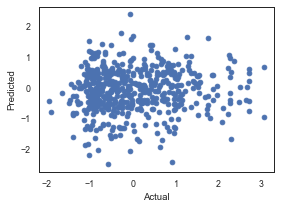

anger SCARED_P_SC


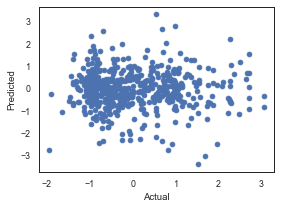

fear SCARED_P_SC


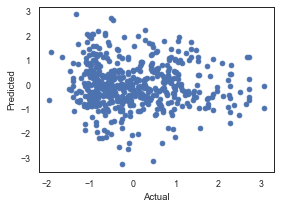

loudness SCARED_P_SC


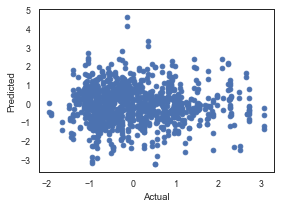

brightness SCARED_P_SC


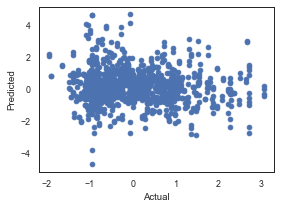

negative SCARED_SR_SC


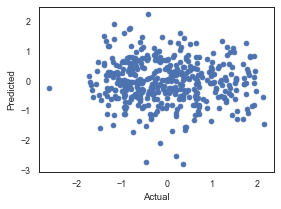

anger SCARED_SR_SC


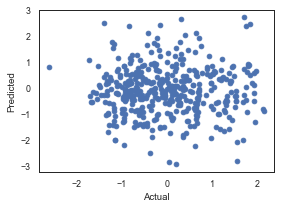

fear SCARED_SR_SC


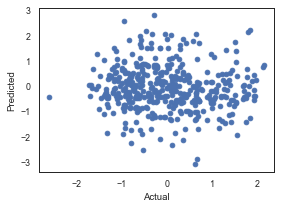

loudness SCARED_SR_SC


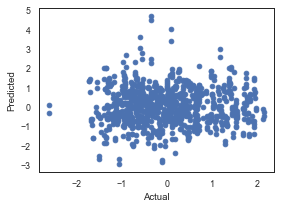

brightness SCARED_SR_SC


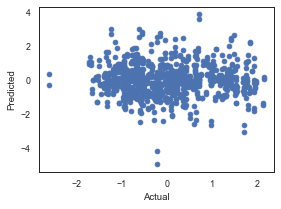

negative SCARED_P_GD


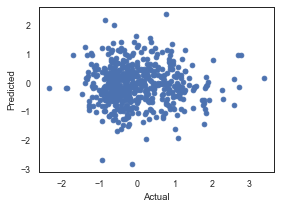

anger SCARED_P_GD


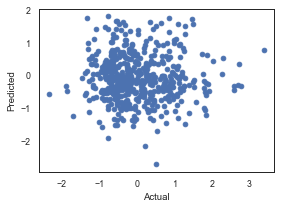

fear SCARED_P_GD


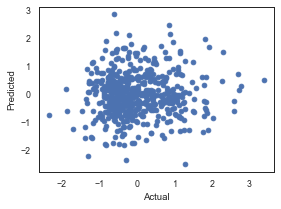

loudness SCARED_P_GD


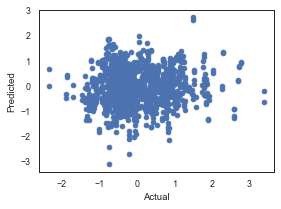

brightness SCARED_P_GD


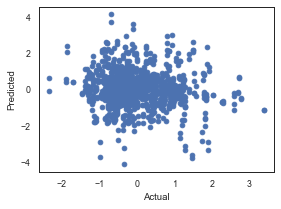

negative SCARED_SR_GD


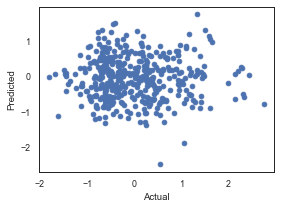

anger SCARED_SR_GD


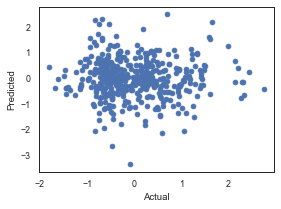

fear SCARED_SR_GD


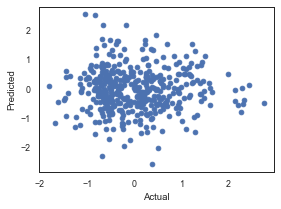

loudness SCARED_SR_GD


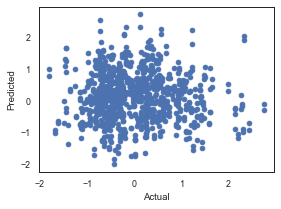

brightness SCARED_SR_GD


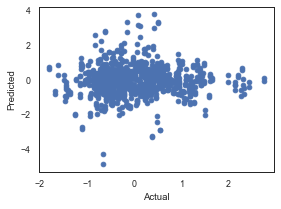

negative SCARED_P_SP


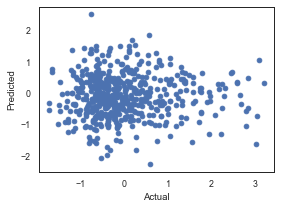

anger SCARED_P_SP


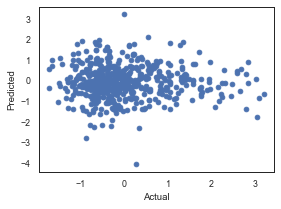

fear SCARED_P_SP


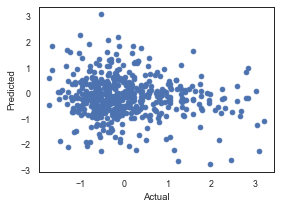

loudness SCARED_P_SP


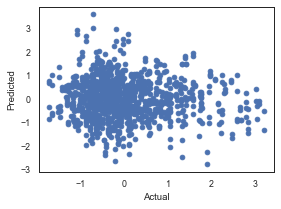

brightness SCARED_P_SP


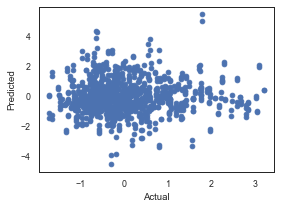

negative SCARED_SR_SP


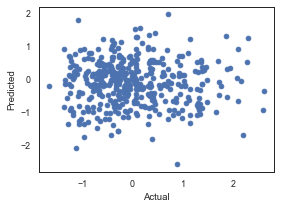

anger SCARED_SR_SP


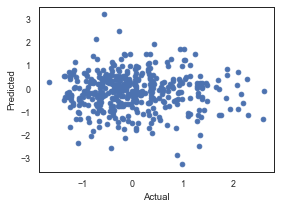

fear SCARED_SR_SP


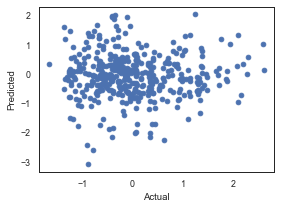

loudness SCARED_SR_SP


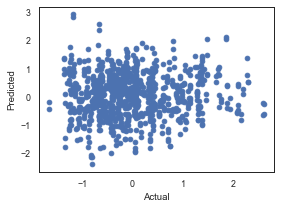

brightness SCARED_SR_SP


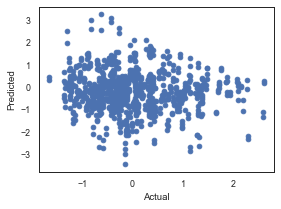

In [24]:
for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
    if 'SR' in clin:
        other = 'MFQ_SR_Total'
    else:
        other = 'MFQ_P_Total'

    for emo in ['negative','anger','fear','loudness','brightness']:
        print(emo, clin)
        # subset training and testing data
        X_train = train_data[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        Y_train = train_labels[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        groups = train_labels['sub'][np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        X_test = test_data[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo)]
        Y_test = test_labels[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo)]
        out_folder = os.path.join(out_dir,'both_movies', emo, clin) + '/'

        # regress out covariates from labels
        Y_train.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_train.loc[:,['age', 'meanFD', clin, other]])
        Y_train.loc[:,['age', 'female', 'meanFD', clin, other]] = \
        IterativeImputer(random_state=42).fit_transform(Y_train.loc[:,['age', 'female', 'meanFD', clin, other]])
        res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_train).fit()
        Y_train = res.resid.to_frame().iloc[:,0]
        
        Y_test.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_test.loc[:,['age', 'meanFD', clin, other]])
        Y_test.loc[:,['age', 'female', 'meanFD', clin, other]] = \
        IterativeImputer(random_state=42).fit_transform(Y_test.loc[:,['age', 'female', 'meanFD', clin, other]])
        res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_test).fit()
        Y_test = res.resid.to_frame().iloc[:,0]

        # run models
        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.plot_weights(sample_file)
        svc.plot_consistency()
        plt.close()
        if (svc.test_score.loc['SpearmanR','pval']<0.05) & (svc.test_score.loc['SpearmanR','stat']>0):
                svc.boot_predict(kind='regress')
                if svc.bootstrap_test.loc['spearmanr','lowerCI']>0:
                    svc.calc_permuted_pvalue(kind='regress')
                    svc.get_perm_importance()

negative SCARED_P_SC


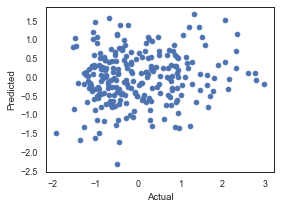

anger SCARED_P_SC


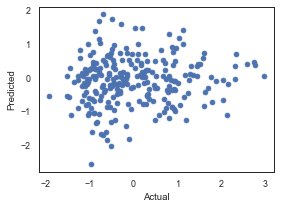

fear SCARED_P_SC


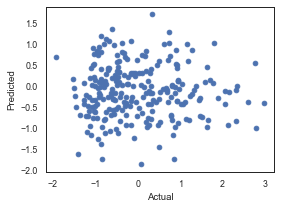

loudness SCARED_P_SC


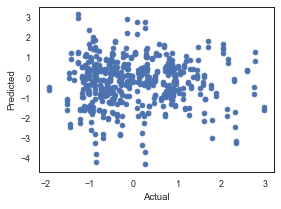

brightness SCARED_P_SC


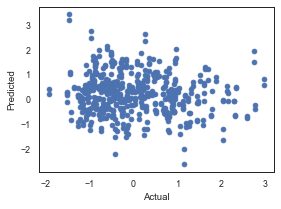

negative SCARED_SR_SC


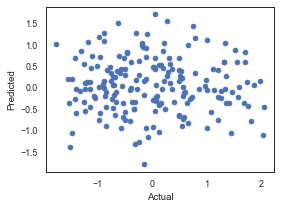

anger SCARED_SR_SC


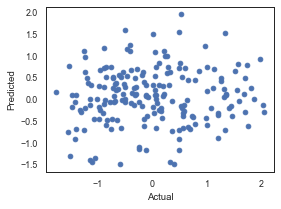

fear SCARED_SR_SC


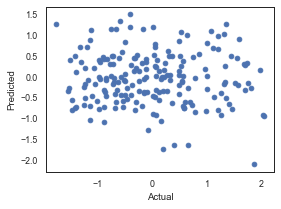

loudness SCARED_SR_SC


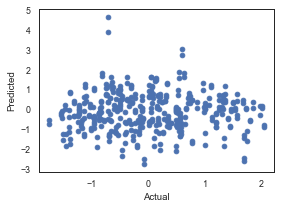

brightness SCARED_SR_SC


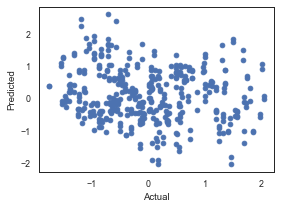

negative SCARED_P_GD


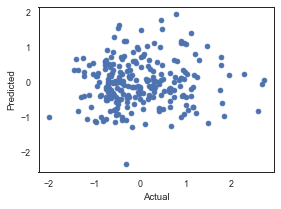

anger SCARED_P_GD


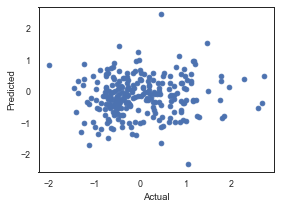

fear SCARED_P_GD


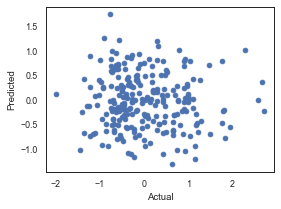

loudness SCARED_P_GD


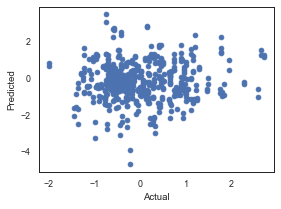

brightness SCARED_P_GD


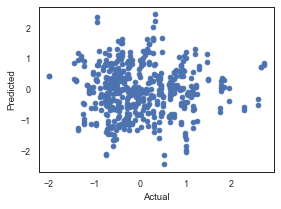

negative SCARED_SR_GD


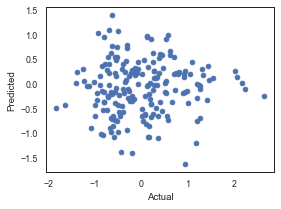

anger SCARED_SR_GD


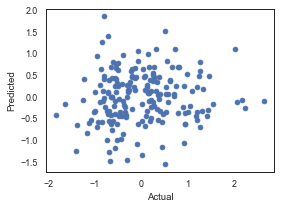

fear SCARED_SR_GD


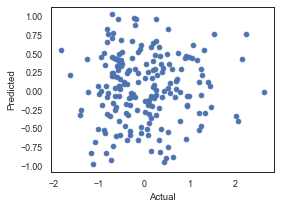

loudness SCARED_SR_GD


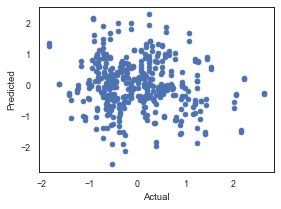

brightness SCARED_SR_GD


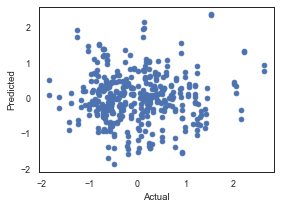

negative SCARED_P_SP


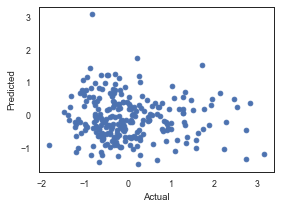

anger SCARED_P_SP


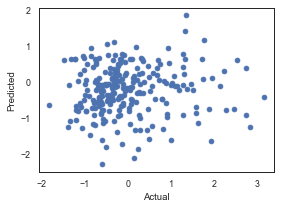

fear SCARED_P_SP


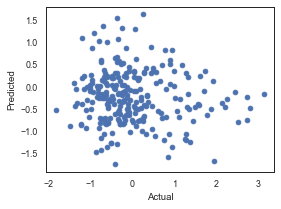

loudness SCARED_P_SP


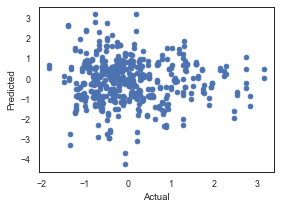

brightness SCARED_P_SP


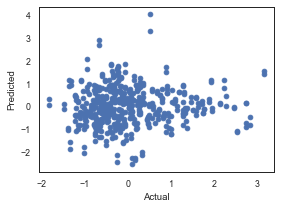

negative SCARED_SR_SP


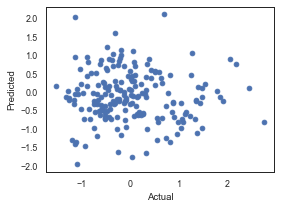

anger SCARED_SR_SP


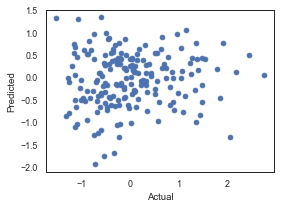

fear SCARED_SR_SP


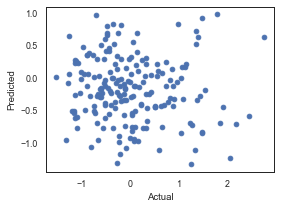

loudness SCARED_SR_SP


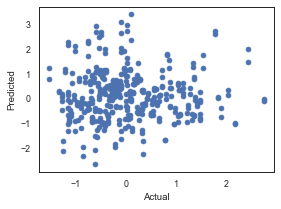

brightness SCARED_SR_SP


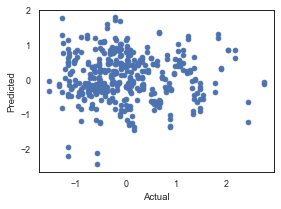

negative SCARED_P_SC


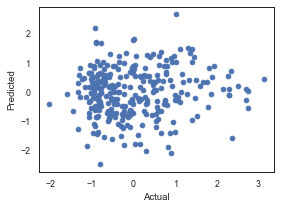

anger SCARED_P_SC


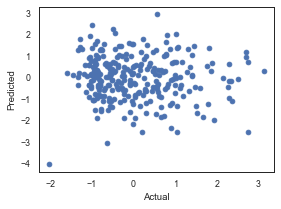

fear SCARED_P_SC


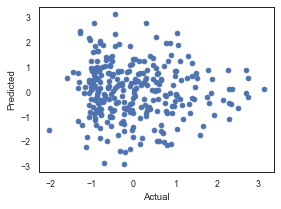

loudness SCARED_P_SC


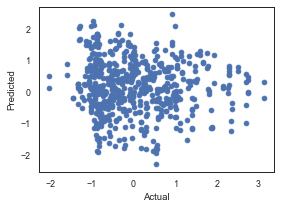

brightness SCARED_P_SC


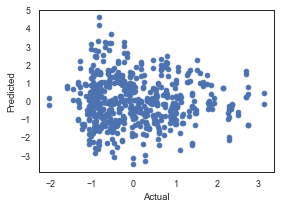

negative SCARED_SR_SC


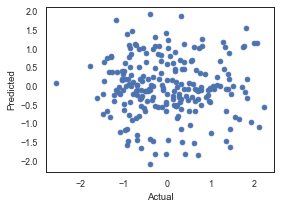

anger SCARED_SR_SC


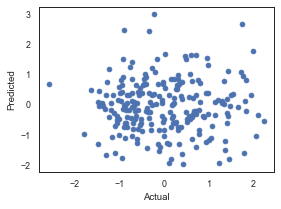

fear SCARED_SR_SC


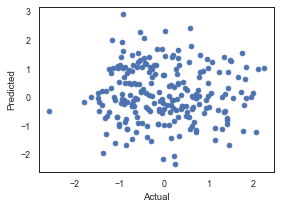

loudness SCARED_SR_SC


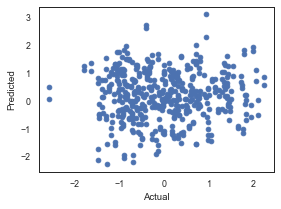

brightness SCARED_SR_SC


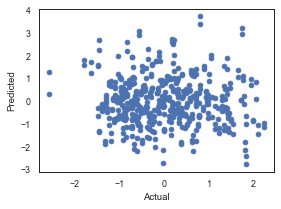

negative SCARED_P_GD


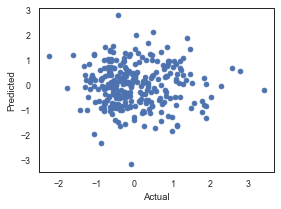

anger SCARED_P_GD


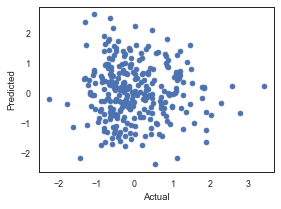

fear SCARED_P_GD


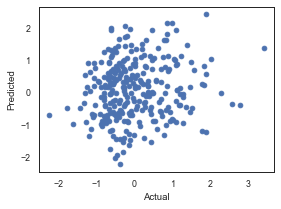

loudness SCARED_P_GD


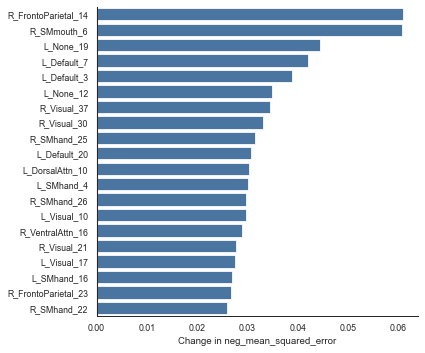

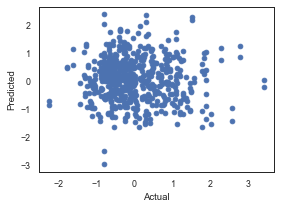

brightness SCARED_P_GD


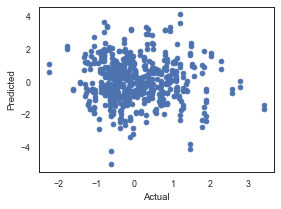

negative SCARED_SR_GD


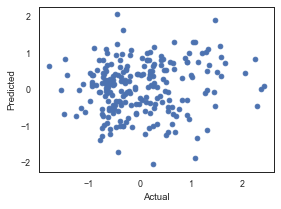

anger SCARED_SR_GD


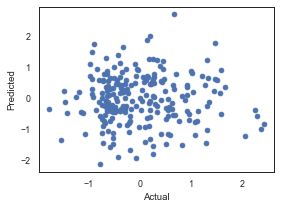

fear SCARED_SR_GD


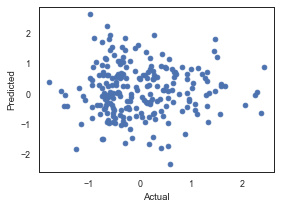

loudness SCARED_SR_GD


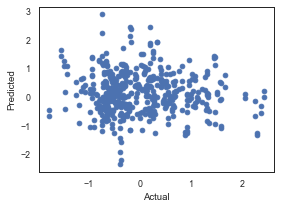

brightness SCARED_SR_GD


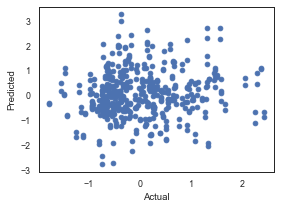

KeyboardInterrupt: 

In [15]:
for mov in ['DM','TP']:
    for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
        if 'SR' in clin:
            other = 'MFQ_SR_Total'
        else:
            other = 'MFQ_P_Total'

        for emo in ['negative','anger','fear','loudness','brightness']:
            print(emo, clin)
            # subset training and testing data
            X_train = train_data[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            Y_train = train_labels[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            groups = train_labels['sub'][np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            X_test = test_data[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo) & (test_labels['movie']==mov)]
            Y_test = test_labels[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo) & (test_labels['movie']==mov)]
            out_folder = os.path.join(out_dir,'movie{0}'.format(mov), emo, clin) + '/'

            # regress out covariates from labels
            Y_train.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_train.loc[:,['age', 'meanFD', clin, other]])
            Y_train.loc[:,['age', 'female', 'meanFD', clin, other]] = \
            IterativeImputer(random_state=42).fit_transform(Y_train.loc[:,['age', 'female', 'meanFD', clin, other]])
            res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_train).fit()
            Y_train = res.resid.to_frame().iloc[:,0]

            Y_test.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_test.loc[:,['age', 'meanFD', clin, other]])
            Y_test.loc[:,['age', 'female', 'meanFD', clin, other]] = \
            IterativeImputer(random_state=42).fit_transform(Y_test.loc[:,['age', 'female', 'meanFD', clin, other]])
            res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_test).fit()
            Y_test = res.resid.to_frame().iloc[:,0]

            # run models
            svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
            svc = svc.fit(X_train, Y_train, groups)
            svc = svc.predict(X_test, Y_test, kind='regress')
            svc.template_outfile = sample_file
            svc.plot_consistency()
            plt.close()
            if (svc.test_score.loc['SpearmanR','pval']<0.05) & (svc.test_score.loc['SpearmanR','stat']>0):
                svc.boot_predict(kind='regress')
                if svc.bootstrap_test.loc['spearmanr','lowerCI']>0:
                    svc.calc_permuted_pvalue(kind='regress')
                    svc.get_perm_importance()


# Is there a curvilinear association between social anxiety and activation to emotional content?

In [25]:
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='rbf')

out_dir = os.path.join(clin_dir, 'SVM_curvilinear')
os.makedirs(out_dir,exist_ok=True)

negative SCARED_P_SC
anger SCARED_P_SC
fear SCARED_P_SC
loudness SCARED_P_SC
brightness SCARED_P_SC
negative SCARED_SR_SC
anger SCARED_SR_SC
fear SCARED_SR_SC
loudness SCARED_SR_SC
brightness SCARED_SR_SC
negative SCARED_P_GD
anger SCARED_P_GD
fear SCARED_P_GD
loudness SCARED_P_GD
brightness SCARED_P_GD
negative SCARED_SR_GD
anger SCARED_SR_GD
fear SCARED_SR_GD
loudness SCARED_SR_GD
brightness SCARED_SR_GD
negative SCARED_P_SP
anger SCARED_P_SP
fear SCARED_P_SP
loudness SCARED_P_SP
brightness SCARED_P_SP
negative SCARED_SR_SP
anger SCARED_SR_SP
fear SCARED_SR_SP
loudness SCARED_SR_SP
brightness SCARED_SR_SP


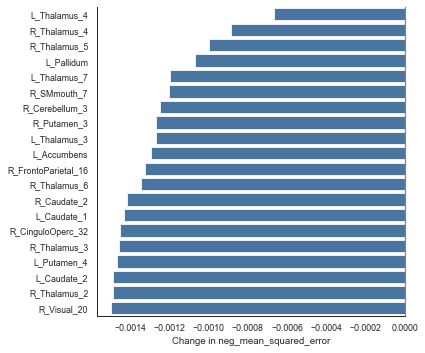

In [26]:
for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
    if 'SR' in clin:
        other = 'MFQ_SR_Total'
    else:
        other = 'MFQ_P_Total'

    for emo in ['negative','anger','fear','loudness','brightness']:
        print(emo, clin)
        # subset training and testing data
        X_train = train_data[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        Y_train = train_labels[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        groups = train_labels['sub'][np.isfinite(train_labels[clin]) & (train_labels['cond']==emo)]
        X_test = test_data[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo)]
        Y_test = test_labels[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo)]
        out_folder = os.path.join(out_dir,'both_movies', emo, clin) + '/'

        # regress out covariates from labels
        Y_train.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_train.loc[:,['age', 'meanFD', clin, other]])
        Y_train.loc[:,['age', 'female', 'meanFD', clin, other]] = \
        IterativeImputer(random_state=42).fit_transform(Y_train.loc[:,['age', 'female', 'meanFD', clin, other]])
        res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_train).fit()
        Y_train = res.resid.to_frame().iloc[:,0]
        
        Y_test.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_test.loc[:,['age', 'meanFD', clin, other]])
        Y_test.loc[:,['age', 'female', 'meanFD', clin, other]] = \
        IterativeImputer(random_state=42).fit_transform(Y_test.loc[:,['age', 'female', 'meanFD', clin, other]])
        res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_test).fit()
        Y_test = res.resid.to_frame().iloc[:,0]

        # run models
        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.template_outfile = sample_file
        if (svc.test_score.loc['SpearmanR','pval']<0.05) & (svc.test_score.loc['SpearmanR','stat']>0):
                svc.boot_predict(kind='regress')
                if svc.bootstrap_test.loc['spearmanr','lowerCI']>0:
                    svc.calc_permuted_pvalue(kind='regress')
                    svc.get_perm_importance()

negative SCARED_P_SC


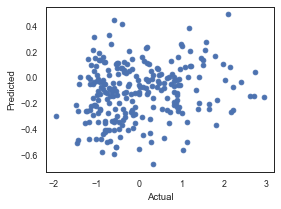

anger SCARED_P_SC


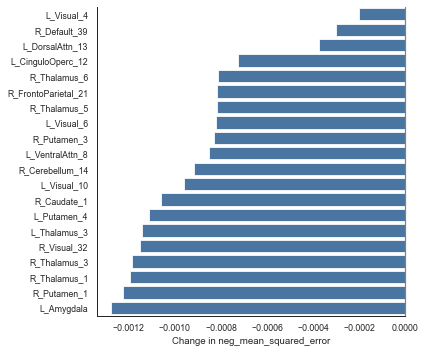

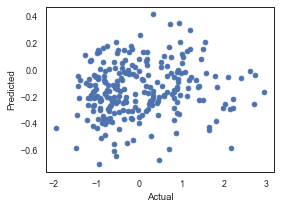

fear SCARED_P_SC


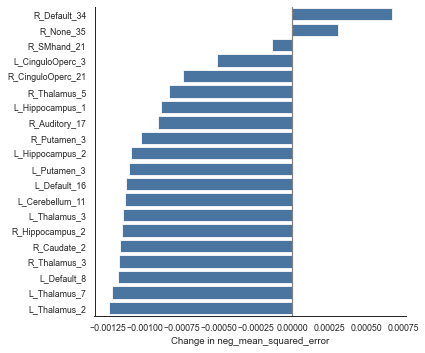

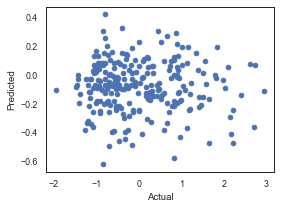

loudness SCARED_P_SC


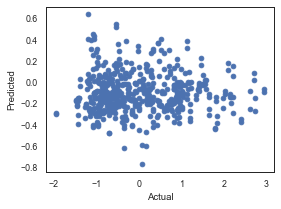

brightness SCARED_P_SC


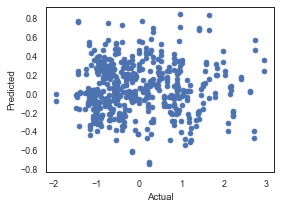

negative SCARED_SR_SC


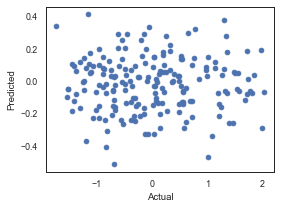

anger SCARED_SR_SC


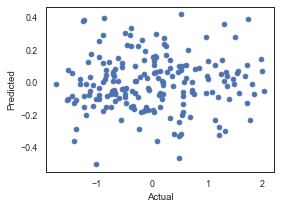

fear SCARED_SR_SC


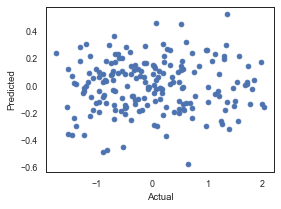

loudness SCARED_SR_SC


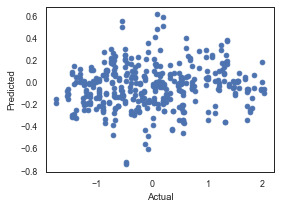

brightness SCARED_SR_SC


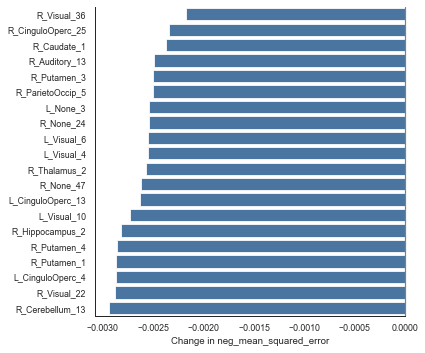

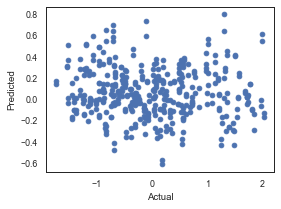

negative SCARED_P_GD


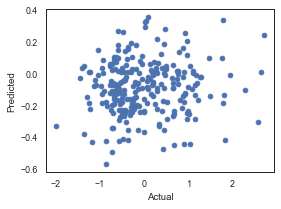

anger SCARED_P_GD


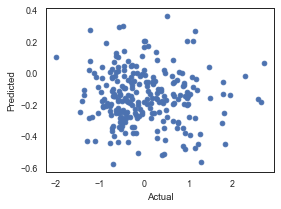

fear SCARED_P_GD


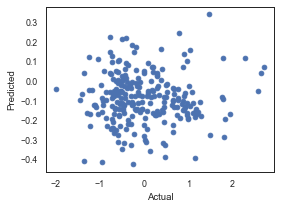

loudness SCARED_P_GD


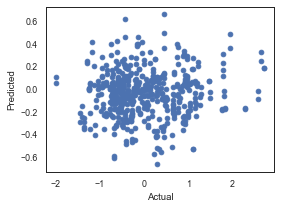

brightness SCARED_P_GD


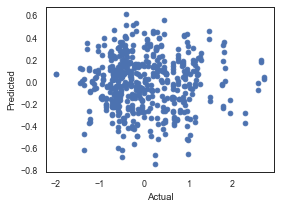

negative SCARED_SR_GD


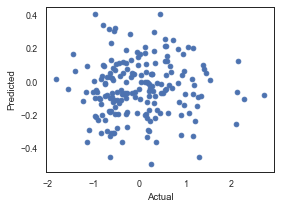

anger SCARED_SR_GD


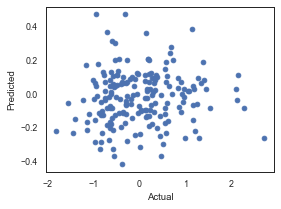

fear SCARED_SR_GD


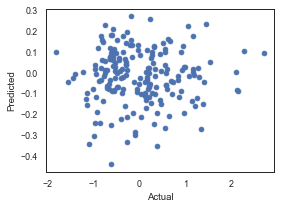

loudness SCARED_SR_GD


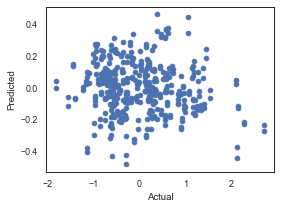

brightness SCARED_SR_GD


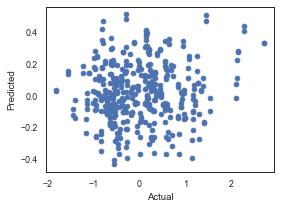

negative SCARED_P_SP


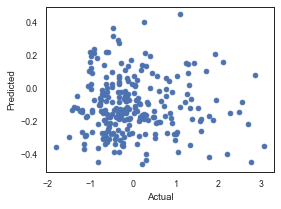

anger SCARED_P_SP


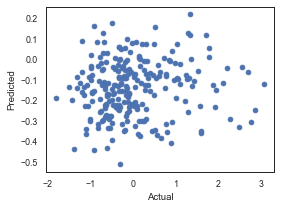

fear SCARED_P_SP


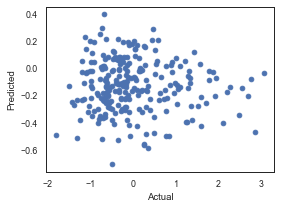

loudness SCARED_P_SP


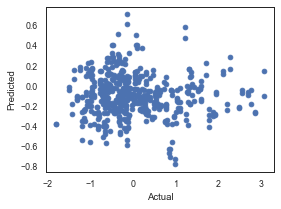

brightness SCARED_P_SP


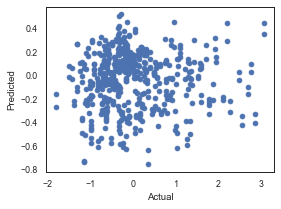

negative SCARED_SR_SP


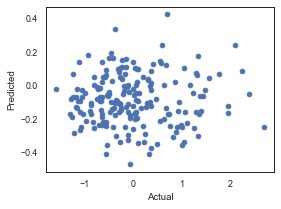

anger SCARED_SR_SP


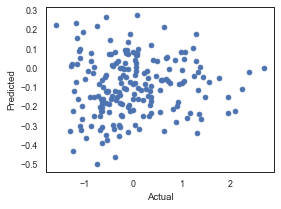

fear SCARED_SR_SP


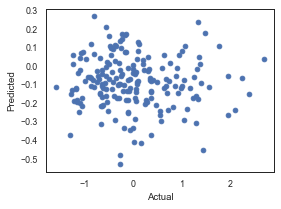

loudness SCARED_SR_SP


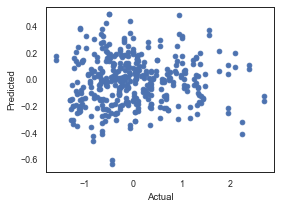

brightness SCARED_SR_SP


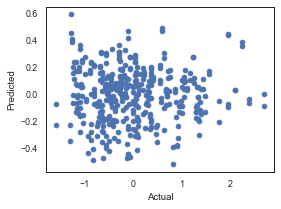

negative SCARED_P_SC


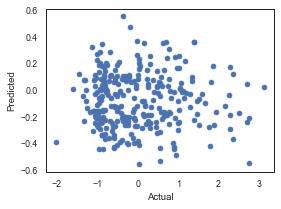

anger SCARED_P_SC


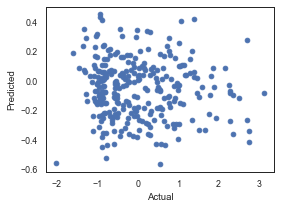

fear SCARED_P_SC


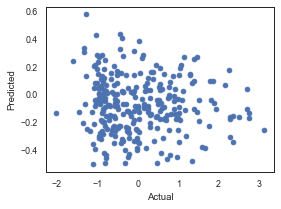

loudness SCARED_P_SC


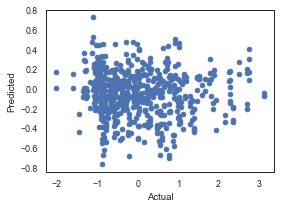

brightness SCARED_P_SC


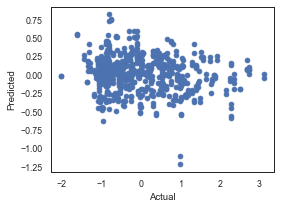

negative SCARED_SR_SC


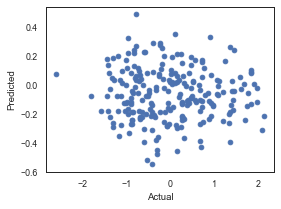

anger SCARED_SR_SC


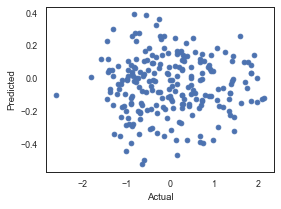

fear SCARED_SR_SC


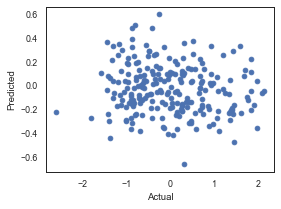

loudness SCARED_SR_SC


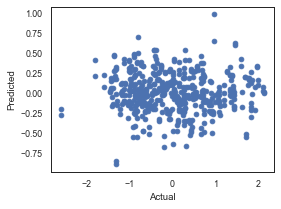

brightness SCARED_SR_SC


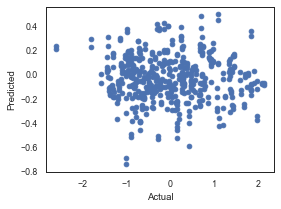

negative SCARED_P_GD


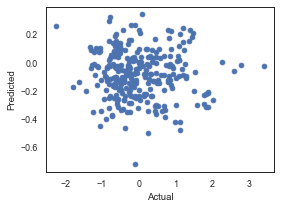

anger SCARED_P_GD


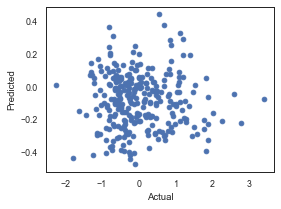

fear SCARED_P_GD


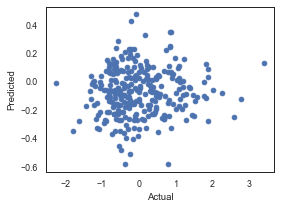

loudness SCARED_P_GD


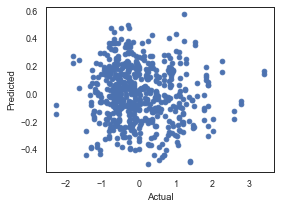

brightness SCARED_P_GD


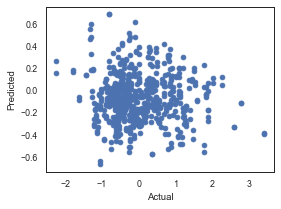

negative SCARED_SR_GD


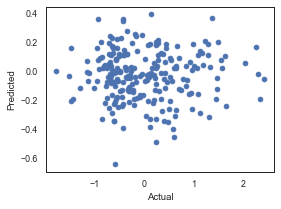

anger SCARED_SR_GD


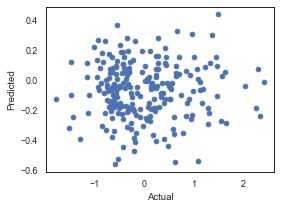

fear SCARED_SR_GD


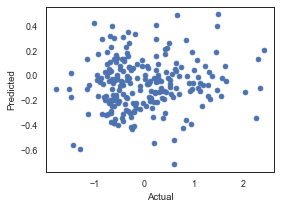

loudness SCARED_SR_GD


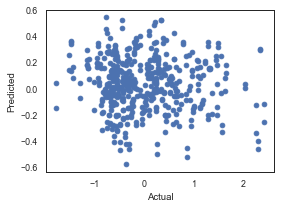

brightness SCARED_SR_GD


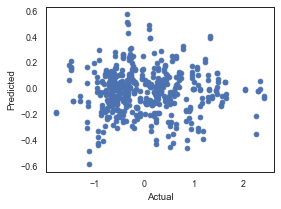

negative SCARED_P_SP


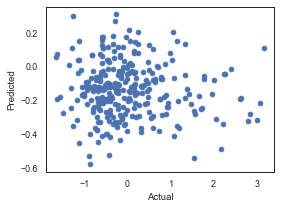

anger SCARED_P_SP


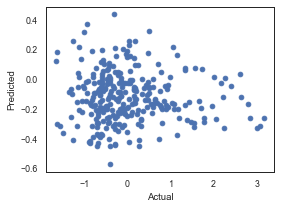

fear SCARED_P_SP


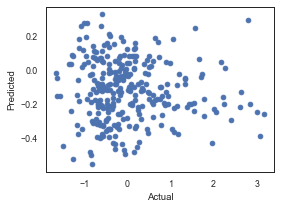

loudness SCARED_P_SP


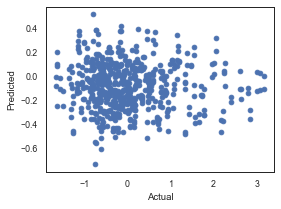

brightness SCARED_P_SP


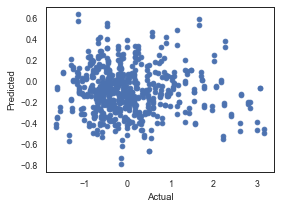

negative SCARED_SR_SP


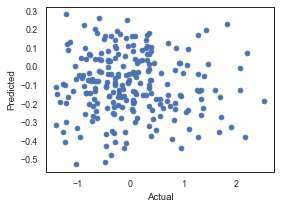

anger SCARED_SR_SP


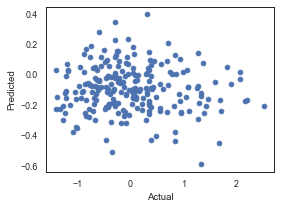

fear SCARED_SR_SP


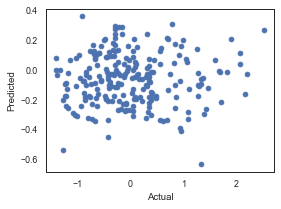

loudness SCARED_SR_SP


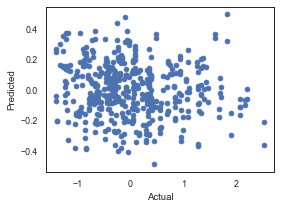

brightness SCARED_SR_SP


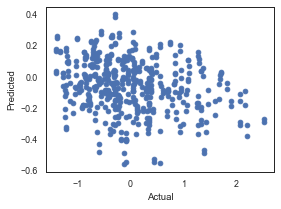

In [27]:
for mov in ['DM','TP']:
    for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
        if 'SR' in clin:
            other = 'MFQ_SR_Total'
        else:
            other = 'MFQ_P_Total'

        for emo in ['negative','anger','fear','loudness','brightness']:
            print(emo, clin)
            # subset training and testing data
            X_train = train_data[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            Y_train = train_labels[np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            groups = train_labels['sub'][np.isfinite(train_labels[clin]) & (train_labels['cond']==emo) & (train_labels['movie']==mov)]
            X_test = test_data[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo) & (test_labels['movie']==mov)]
            Y_test = test_labels[np.isfinite(test_labels[clin]) & (test_labels['cond']==emo) & (test_labels['movie']==mov)]
            out_folder = os.path.join(out_dir,'movie{0}'.format(mov), emo, clin) + '/'

            # regress out covariates from labels
            Y_train.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_train.loc[:,['age', 'meanFD', clin, other]])
            Y_train.loc[:,['age', 'female', 'meanFD', clin, other]] = \
            IterativeImputer(random_state=42).fit_transform(Y_train.loc[:,['age', 'female', 'meanFD', clin, other]])
            res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_train).fit()
            Y_train = res.resid.to_frame().iloc[:,0]

            Y_test.loc[:,['age','meanFD', clin, other]] = StandardScaler().fit_transform(Y_test.loc[:,['age', 'meanFD', clin, other]])
            Y_test.loc[:,['age', 'female', 'meanFD', clin, other]] = \
            IterativeImputer(random_state=42).fit_transform(Y_test.loc[:,['age', 'female', 'meanFD', clin, other]])
            res = smf.ols('{0} ~ age + female + meanFD + {1}'.format(clin, other), data=Y_test).fit()
            Y_test = res.resid.to_frame().iloc[:,0]

            # run models
            svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
            svc = svc.fit(X_train, Y_train, groups, kernel='poly')
            svc = svc.predict(X_test, Y_test, kind='regress')
            svc.template_outfile = sample_file
            svc.plot_consistency()
            plt.close()
            if (svc.test_score.loc['SpearmanR','pval']<0.05) & (svc.test_score.loc['SpearmanR','stat']>0):
                svc.boot_predict(kind='regress')
                if svc.bootstrap_test.loc['spearmanr','lowerCI']>0:
                    svc.calc_permuted_pvalue(kind='regress')
                    svc.get_perm_importance()


# Compile results

In [41]:
out_dir = os.path.join(clin_dir, 'SVM_linear')

for mov in ['both_movies']:#,'movieDM','movieTP']:
    for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
        results = pd.DataFrame(columns=['clin','activation','spearmanr','spearmanCI','spearmanp','pearsonr','pearsonCI','pearsonp','MSE'])
        idx = 0
        for emo in ['negative','anger','fear','loudness','brightness']:
            results.loc[idx, 'clin'] = clin
            results.loc[idx, 'activation'] = emo
            res = pd.read_csv(os.path.join(out_dir,mov, emo, clin, 'performance_report.csv'), index_col = 0)
            results.loc[idx, 'spearmanr'] = res.loc['SpearmanR','stat']
            results.loc[idx, 'spearmanp'] = res.loc['SpearmanR','pval']
            results.loc[idx, 'pearsonr'] = res.loc['PearsonR','stat']
            results.loc[idx, 'pearsonp'] = res.loc['PearsonR','pval']
            results.loc[idx, 'MSE'] = res.loc['MSE','stat']
            if os.path.exists(os.path.join(out_dir,mov, emo, clin, 'bootstrapped_test_accuracy_randN.csv')):
                boot  = pd.read_csv(os.path.join(out_dir,mov, emo, clin, 'bootstrapped_test_accuracy_randN.csv'), index_col = 0)
                results.loc[idx, 'spearmanr'] = boot.loc['spearmanr','boot_mean']
                results.loc[idx, 'spearmanCI'] = '[{0}, {1}]'.format(round(boot.loc['spearmanr','lowerCI'],2), round(boot.loc['spearmanr','upperCI'],2))
                results.loc[idx, 'pearsonr'] = boot.loc['pearsonr','boot_mean']
                results.loc[idx, 'pearsonCI'] = '[{0}, {1}]'.format(round(boot.loc['pearsonr','lowerCI'],2), round(boot.loc['pearsonr','upperCI'],2))
            idx = idx + 1
        results.to_csv(os.path.join(out_dir,mov,'compiled_stats_{0}.csv'.format(clin)))